- classification
- detection
- segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. ImageDataGenerator
- 원본 이미지에 적절한 변형을 가해서 새로운 데이터를 만드는 방식
- 텐서플로우에서는 이미지 데이터 보강을 위해 ImageDataGenerator 제공
- flow_from_directory()

    ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        brightness_range=None,
        shear_range=0.0,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=False,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        interpolation_order=1,
        dtype=None,
    )

In [3]:
?ImageDataGenerator

In [4]:
with zipfile.ZipFile("data/test_img_dir.zip", "r") as target_file:
    target_file.extractall("data/")

In [5]:
gen= ImageDataGenerator(rotation_range=10, 
                        shear_range=0.2, 
                        horizontal_flip=True,  # 랜덤으로 실행됨(정규화 제외)
                        rescale=1./255)

In [30]:
data_gen= gen.flow_from_directory(directory='data/test_img_dir/', 
                                  batch_size=4, 
                                  shuffle= True, 
                                  target_size=(100,100), 
                                  class_mode='sparse')

Found 12 images belonging to 3 classes.


In [31]:
print(data_gen.class_indices)
print(data_gen.num_classes)
print(data_gen.class_mode)

{'cat': 0, 'deer': 1, 'dog': 2}
3
sparse


label-> 0.0
label-> 1.0
label-> 1.0
label-> 2.0


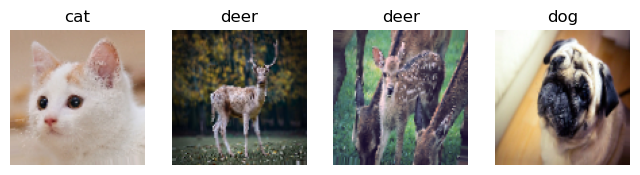

In [38]:
img, label= data_gen.next()
class_names= {0:'cat', 1:'deer', 2:'dog'}

for i in range(len(label)):
    print('label->', label[i])
    
plt.figure(figsize=(8,8))
for i in range(len(img)):
    plt.subplot(1, len(img), i+1)
    plt.title(class_names[int(label[i])])
    plt.imshow(img[i])
    plt.axis('off')

In [33]:
len(img)

4

In [36]:
data_gen.directory

'data/test_img_dir/'

# 2. Cats and Dogs
## (1) binary

In [123]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

train_data_gens=ImageDataGenerator(rotation_range=10, shear_range=0.2, horizontal_flip=True, 
                                   width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1,rescale=1./255)
test_data_gens= ImageDataGenerator(rescale=1./255)

train_dir= 'content/cats_and_dogs_filtered/train'
test_dir= 'content/cats_and_dogs_filtered/validation'

train_data= train_data_gens.flow_from_directory(directory=train_dir, 
                                  batch_size=4, 
                                  shuffle= True, 
                                  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                  class_mode='sparse') # 이진일때 binary, 다중일때 saprse/categorical

test_data= test_data_gens.flow_from_directory(directory=test_dir, 
                                  batch_size=4, 
                                  shuffle= True, 
                                  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                  class_mode='sparse')

# print(train_data.class_indices)
# print(train_data.num_classes)

# print(test_data.class_indices)
# print(test_data.num_classes)

#### X_train, y_train= train_data.next()
#### X_test, y_test= test_data.next()



base_model= MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
# base_model.summary()

# base_model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc'])

model= Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid')) # 이진분류. loss='binary_crossentropy'
# model.add(Dense(2, activation='softmax')) # 다중분류. loss= 'sparse_categorical_crossentropy'


model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

# model.summary()

start_time = datetime.now()

result = model.fit(train_data,
                 epochs=3, batch_size=32, 
                 validation_data=test_data)

end_time = datetime.now()

model.evaluate(test_data)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/3
500/500 [==============================] - 161s 312ms/step - loss: 0.3235 - acc: 0.8620 - val_loss: 0.0770 - val_acc: 0.9780
Epoch 2/3
500/500 [==============================] - 152s 304ms/step - loss: 0.1698 - acc: 0.9375 - val_loss: 0.0714 - val_acc: 0.9720
Epoch 3/3
250/250 [==============================] - 15s 61ms/step - loss: 0.0660 - acc: 0.9750


[0.06596918404102325, 0.9750000238418579]

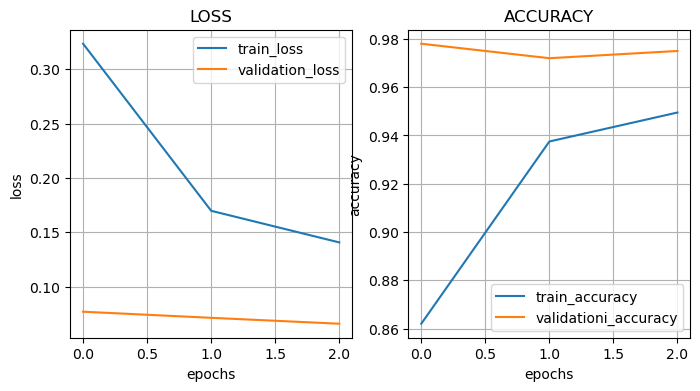

In [124]:
### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

In [125]:
model.evaluate(test_data)

250/250 [==============================] - 15s 62ms/step - loss: 0.0660 - acc: 0.9750


[0.06596919149160385, 0.9750000238418579]

### 테스트 이미지 확인

In [128]:
test_img_list=[]
test_img_name_list= glob.glob('data/test_image/*')

for i in range(len(test_img_name_list)):
    src_img= cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img= cv2.resize(src_img, dsize=[IMAGE_WIDTH, IMAGE_HEIGHT])
    dst_img= cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img= dst_img/255.0
    test_img_list.append(dst_img)
    
print(np.array(test_img_list).shape)

(12, 224, 224, 3)


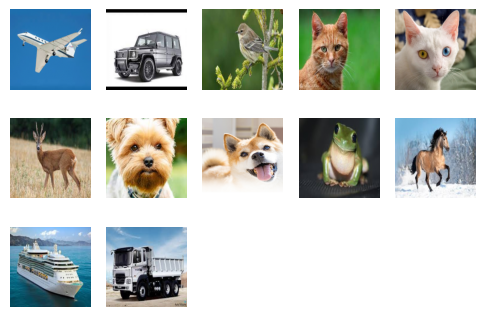

In [129]:
plt.figure(figsize=(6,4))

for i in range(len(test_img_list)):
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

In [130]:
pred= model.predict(np.array(test_img_list))

1/1 [==============================] - 0s 414ms/step


In [131]:
print(pred.shape)
print(pred)

(12, 1)
[[5.7075071e-01]
 [8.4723783e-01]
 [9.5033729e-01]
 [4.0160830e-06]
 [7.3066542e-05]
 [9.8126245e-01]
 [9.9943197e-01]
 [6.3490337e-01]
 [5.4756558e-01]
 [9.9652183e-01]
 [6.9686085e-01]
 [5.0727099e-01]]


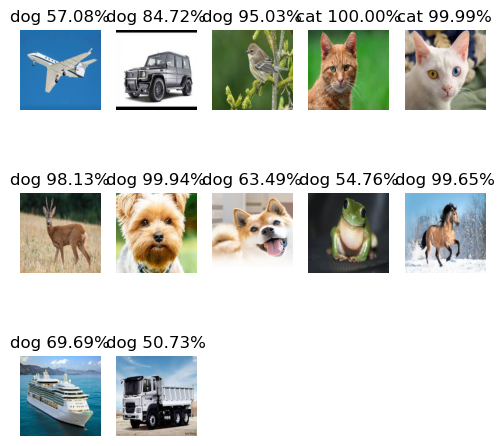

In [132]:
plt.figure(figsize=(6,6))

for i in range(len(test_img_list)):
    if pred[i]>0.5:
        prob=pred[i]
        prediction='dog'
    else:
        prob= 1-pred[i]
        prediction='cat'
        
    prob_str= str(' {0:0.2f}'.format(100*max(prob)))+'%'
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])
    plt.title(prediction+prob_str)

## (2) categorical

In [137]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


train_data_gen = ImageDataGenerator(rotation_range=10, shear_range=0.2, horizontal_flip=True, rescale=1./255,
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'content/cats_and_dogs_filtered/train'
test_dir = 'content/cats_and_dogs_filtered/validation'


train_data = gen.flow_from_directory(directory=train_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')
test_data = gen.flow_from_directory(directory=test_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')

print(train_data.class_indices)
print(train_data.num_classes)

print(test_data.class_indices)
print(test_data.num_classes)

base_model = MobileNet(weights='imagenet', include_top = False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
base_model.summary()

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=32, validation_data=test_data)

end_time = datetime.now()



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                              

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\acorn\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\acorn\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\acorn\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\acorn\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\acorn\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\acorn\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\acorn\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\acorn\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\acorn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\acorn\AppData\Local\Temp\ipykernel_34240\356165110.py", line 38, in <module>
      result = model.fit(train_data, epochs=3, batch_size=32, validation_data=test_data)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\acorn\anaconda3\lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [4,2] and labels shape [8]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_173394]

In [140]:
pred= model.predict(np.array(test_img_list))

1/1 [==============================] - 1s 543ms/step


In [141]:
print(pred.shape)
print(pred)

(12, 2)
[[3.3745199e-01 6.6254801e-01]
 [4.7554186e-01 5.2445817e-01]
 [1.6181993e-03 9.9838185e-01]
 [1.0000000e+00 1.5263117e-10]
 [1.0000000e+00 9.8478115e-10]
 [1.3553645e-01 8.6446351e-01]
 [1.4539874e-07 9.9999988e-01]
 [3.0658484e-01 6.9341516e-01]
 [5.9434265e-01 4.0565738e-01]
 [2.6005290e-08 1.0000000e+00]
 [8.4359741e-01 1.5640257e-01]
 [3.4401777e-01 6.5598226e-01]]


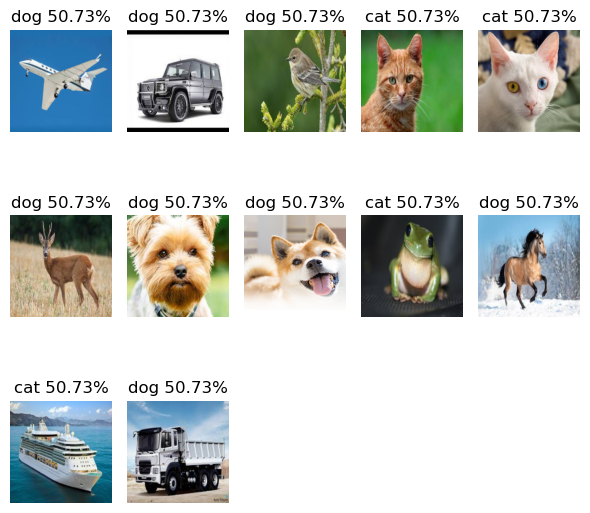

In [142]:
plt.figure(figsize=(6,6))

class_name= ['cat','dog']

for i in range(len(pred)):
    plt.subplot(3,5,i+1)
    plt.axis('off')

    prediction= class_name[np.argmax(pred[i])]
    prob_str= str(' {0:0.2f}'.format(100*max(prob)))+'%'
    plt.title(prediction+prob_str)
    plt.imshow(test_img_list[i])

plt.tight_layout()

# 3. Validation Split
- ImageDataGenerator(validation_split= 0.0)

Found 1600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
     

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

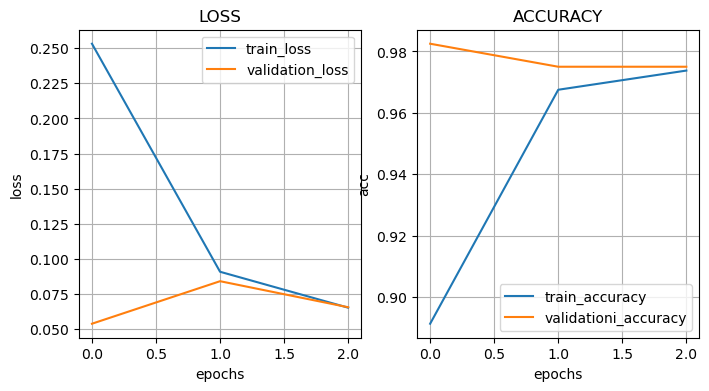

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


train_data_gen = ImageDataGenerator(rotation_range=10, 
                                    shear_range=0.2, 
                                    horizontal_flip=True, 
                                    rescale=1./255,
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    zoom_range=0.1,
                                    validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

val_data_gen= ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = 'content/cats_and_dogs_filtered/train'
test_dir = 'content/cats_and_dogs_filtered/validation'

train_data = train_data_gen.flow_from_directory(directory=train_dir, batch_size=32, shuffle=True, 
                                     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),class_mode='binary',
                                    subset='training')
test_data = test_data_gen.flow_from_directory(directory=test_dir, batch_size=32, shuffle=True, 
                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),class_mode='binary')

val_data = val_data_gen.flow_from_directory(directory=train_dir, batch_size=32, shuffle=True, 
                                   target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),class_mode='binary',
                                  subset='validation')

print(train_data.class_indices)
print(train_data.num_classes)

print(test_data.class_indices)
print(test_data.num_classes)

base_model = MobileNet(weights='imagenet', include_top = False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
base_model.summary()

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=32, validation_data=val_data) # next()의 역할

end_time = datetime.now()

#### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

#### kaggle 의료 데이터
- Brain Tumor(Unet)
- Chest Xray
- Blood Cell
- Covid19

[1]  이미지크롤링이나다운로드등을통해서chihuahua, jindo_dog, , yorkshire_terrier, shepherd등의4가지종류의dog이미지를분류하고자한다. 

즉dog_image/train/ 디렉토리아래에해당되는dog이름을나타내는디렉토리를먼저만들고, 다운받은이미지를해당디렉토리에저장한다.

[2]  ImageDataGenerator를이용해서validation data 를만들고, train 데이터의10%를test 디렉토리의동일한디렉토리로move 한다.  

생성된train / validation data 를이용하여오버피팅을최소화하면서90% 이상의정확도를가지도록학습한후, 

학습된가중치를h5 파일로저장하고,  test 데이터를이용해서정확도를계산하시오. (ModelCheckpoint, EarlyStopping등의callback 적용하여학습함)

[3]  또한test 디렉토리의모든데이터를test_image_files디렉토리로copy 하여random하게16개를선택해서prediction 실행하시오

[4]  본인이촬영한이미지나새롭게다운받은이미지등을이용해서학습모델의신뢰성검증

[5]  문제[1] ~ [4] 내용을, image_shape= (224, 224) 또는image_shape= (150, 150) 에대해서MobileNet,  Xception,  InceptionV3,  ResNet50  등의다양한pre-trained model을사용해서학습소요시간, 오버피팅정도, 정확도등을종합적으로평가한후dog breed 데이터에대한본인만의best model 을선택하시오

[6]  best model 을선택하게된근거와기준, 그리고이슈사항등을논의하시오

In [138]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


train_data_gen = ImageDataGenerator(rotation_range=10, shear_range=0.2, horizontal_flip=True, rescale=1./255,
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
validation_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'dog_image/train'
validation_dir= 'dog_image/train'

train_data = gen.flow_from_directory(directory=train_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')
validation_data = gen.flow_from_directory(directory=test_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')

### validation으로부터 test data 분리( 분리 비율은 5 : 5)

s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.1 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]

print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)


Found 805 images belonging to 4 classes.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                              

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

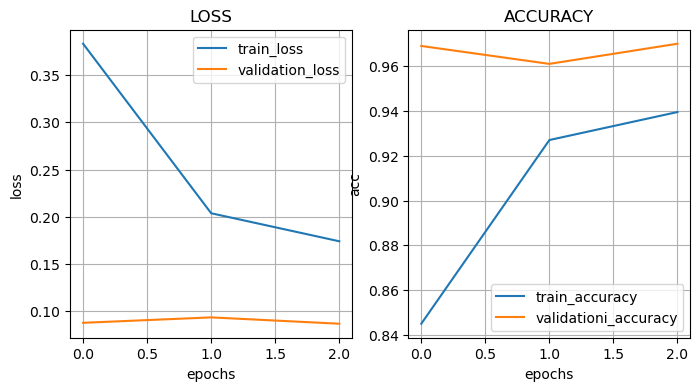

In [139]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


train_data_gen = ImageDataGenerator(rotation_range=10, shear_range=0.2, horizontal_flip=True, rescale=1./255,
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'content/cats_and_dogs_filtered/train'
test_dir = 'content/cats_and_dogs_filtered/validation'

train_data = gen.flow_from_directory(directory=train_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')
test_data = gen.flow_from_directory(directory=test_dir, batch_size=4, shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode='categorical')

print(train_data.class_indices)
print(train_data.num_classes)

print(test_data.class_indices)
print(test_data.num_classes)

base_model = MobileNet(weights='imagenet', include_top = False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
base_model.summary()

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=32, validation_data=test_data)

end_time = datetime.now()



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validation_accuracy')
